In [1]:
#!pip install --user pyarrow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu
from scipy.special import expit as sigmoid

tqdm.pandas()

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
#cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
#cis_eQTL

In [4]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [5]:
model_name = "window-128_tokenization-no_model-bert"
#model_name = "window-1000_tokenization-bpe8192_model-bert"
df = pd.read_parquet(f"vep_{model_name}.parquet")
pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["AF"] = df.AC / df.AN
#df = df[df.AF < 0.5]
df["alt_AF"] = df.AC / df.AN
df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
df["ref_AF"] = 1 - df.alt_AF
df["alt_AC"] = df.AC
df["ref_AC"] = df.AN - df.AC
df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_llr,alt_AF,ref_AF,alt_AC,ref_AC,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,2.236435,0.180943,0.819057,376,1702,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,-2.134256,0.000958,0.999042,2,2086,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,2.495054,0.001896,0.998104,4,2106,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,-0.379902,0.002828,0.997172,6,2116,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,-1.878045,0.000941,0.999059,2,2124,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Chr5,1770443,G,A,930,2046,AT5G05880.1,795,-0.759698,0.545455,0.454545,1116,930,0.454545
99996,Chr5,1770459,A,T,30,2084,AT5G05880.1,811,-0.136648,0.014395,0.985605,30,2054,0.014395
99997,Chr5,1770460,T,G,20,2074,AT5G05880.1,812,-1.101603,0.009643,0.990357,20,2054,0.009643
99998,Chr5,1770613,G,C,2,2002,AT5G05880.1,965,0.031736,0.000999,0.999001,2,2000,0.000999


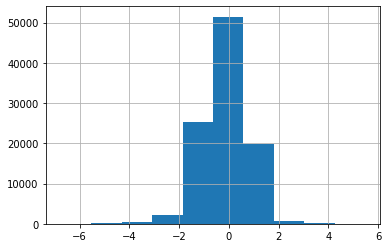

In [6]:
df.model_llr.hist()

In [7]:
spearmanr(df.AC, df.model_llr)

SpearmanrResult(correlation=0.03599959043171414, pvalue=4.8324354659919516e-30)

In [8]:
df["Status"] = "Neither"
df.loc[df.AC <= 10, "Status"] = "Rare"
df.loc[df.AC > 100, "Status"] = "Common"
df.Status.value_counts()

Rare       61237
Neither    23314
Common     15445
Name: Status, dtype: int64

In [9]:
mannwhitneyu(df.loc[df.Status=="Rare", "model_llr"], df.loc[df.Status=="Common", "model_llr"], alternative="less")

MannwhitneyuResult(statistic=446501427.5, pvalue=3.33665218001663e-27)

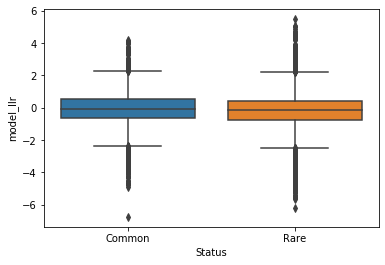

In [10]:
sns.boxplot(data=df[df.Status.isin(["Rare", "Common"])], x="Status", y="model_llr")

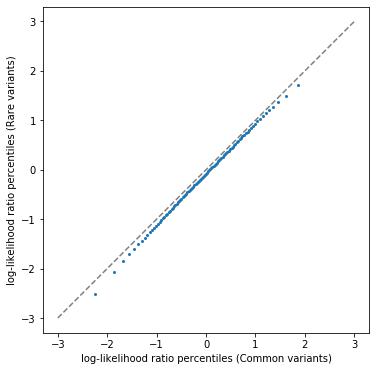

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(
    np.percentile(df[df.Status=="Common"].model_llr, np.arange(1, 100)),
    np.percentile(df[df.Status=="Rare"].model_llr, np.arange(1, 100)),
    s=4,
)
plt.xlabel("log-likelihood ratio percentiles (Common variants)")
plt.ylabel("log-likelihood ratio percentiles (Rare variants)")
plt.plot([-3, 3], [-3, 3], "--", color="gray")
plt.gca().set_aspect('equal', 'box')